# Benckmarking Dataset 1

In [78]:
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
import time
import logging
from sklearn.linear_model import LinearRegression
from scipy.spatial import distance_matrix

import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import shutil
from sklearn.metrics.pairwise import cosine_similarity

# silence scanpy that prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../src')
from utils import *

# Preprocessing MERFISH MOp data
We use a single-cell resolution MERFISH MOp dataset to generate a simulated dataset. The raw MEREFISH MOp dataset is available in [here](https://doi.brainimagelibrary.org). Conveniently, we provided the pre-pocessed benchmarking Dataset 1 (demo_data/MERFISH_mop.h5ad) as well as other relevent materials involved in the following example in [here](https://drive.google.com/drive/folders/1PXv_brtr-tXshBVEd_HSPIagjX9oF7Kg?usp=sharing)

In [143]:
sp_adata = anndata.read_h5ad('../demo_data/MERFISH_mop.h5ad')

sp_adata = sp_adata[~sp_adata.obs['subclass'].isin(['Sncg'])]
sc.pp.filter_cells(sp_adata, min_counts=100)
sc.pp.filter_genes(sp_adata, min_cells=5)
sp_adata.obs_names_make_unique()
sp_adata.var_names_make_unique()

sp_adata.X.max(),sp_adata.X.shape,sp_adata.X.sum(1).max(),sp_adata.X.sum(1).min()

(217.97995, (5272, 254), 562.21814, 100.01511)

In [144]:
sp_adata.obs.head()

sample_id         slice_id  \
100119755510557417791056480683612014915  mouse1_sample4  mouse1_slice180   
100132293312011676013834246988384644937  mouse1_sample4  mouse1_slice180   
100141477907895285159644541629937136293  mouse1_sample4  mouse1_slice180   
100170194898756150593503685585478903524  mouse1_sample4  mouse1_slice180   
100221098919514132063709706431102588200  mouse1_sample4  mouse1_slice180   

                                           class_label subclass         label  \
100119755510557417791056480683612014915  Glutamatergic    L6 CT       L6_CT_5   
100132293312011676013834246988384644937          Other    Oligo       Oligo_1   
100141477907895285159644541629937136293  Glutamatergic  L4/5 IT  L45_IT_SSp_2   
100170194898756150593503685585478903524      GABAergic    Pvalb       Pvalb_1   
100221098919514132063709706431102588200  Glutamatergic    L5 IT       L5_IT_4   

                                                   X            Y    n_counts  
100119755510557417791056480683612014915 -5137.658042  4503.501626  297.209991  
100132293312011676013834246988384644937 -5093.931935  4734.489682  402.076935  
100141477907895285159644541629937136293 -3793.101286  4413.310921  247.275024  
100170194898756150593503685585478903524 -3303.798336  6380.755049  270.361816  
100221098919514132063709706431102588200 -3512.313442  5166.499199  261.730865

In [145]:
sp_adata.obs['subclass'].value_counts()

L2/3 IT       655
L4/5 IT       615
L6 CT         602
Oligo         540
L5 IT         421
L6 IT         376
Astro         365
Endo          348
Pvalb         163
L5 ET         159
Peri          142
OPC           101
Sst            99
Micro          97
L6b            96
L6 IT Car3     87
VLMC           85
SMC            79
PVM            77
L5/6 NP        63
Lamp5          62
Vip            40
Name: subclass, dtype: int64

In [146]:
sp_adata.raw = sp_adata.copy() 

sc.pp.log1p(sp_adata)
sc.pp.pca(sp_adata, svd_solver='arpack', n_comps=30, use_highly_variable=False)
sc.pp.neighbors(sp_adata, metric='cosine', n_neighbors=30, n_pcs = 30)
sc.tl.umap(sp_adata, min_dist = 0.5, spread = 1, maxiter=60)

sp_adata = removeOutliers(sp_adata,'subclass')
sp_adata.shape

(5209, 254)

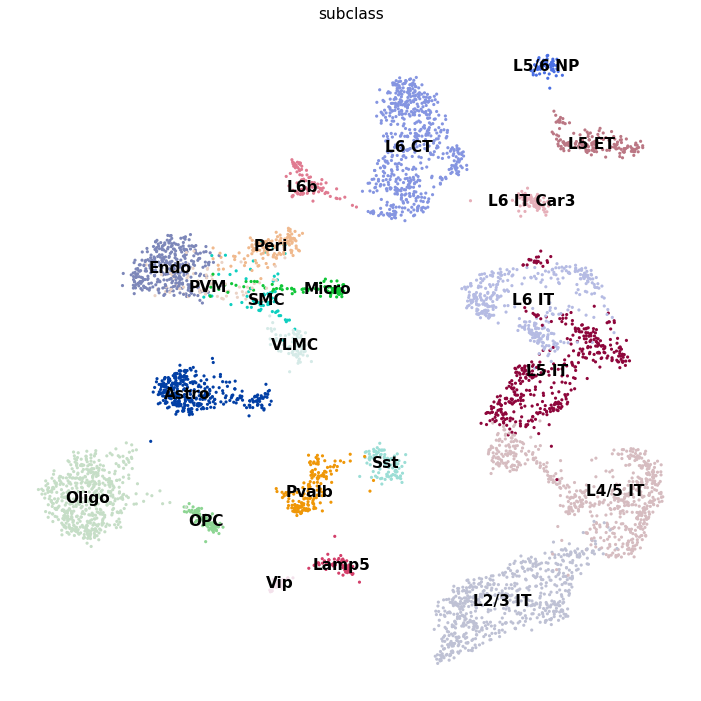

In [147]:
sns.set_context('paper',font_scale=1.6) 

fig, axs = plt.subplots(1, 1, figsize=(10, 10))
sc.pl.umap(
    sp_adata, color="subclass", size=40, frameon=False, show=False, ax=axs,legend_loc='on data'
)
plt.tight_layout()

# Generate Slimulated data

To generate a simulated dataset: The MERFISH data is partitioned into two regions, with one region (right) serving as the single-cell reference data, and the second region (right) serving to mimic low-resolution ST data by aggregating the cells on uniform grids to simulate spots.

In [148]:
# split the dataset to create simulated spatial and single cell data 
simulated_sp = sp_adata[sp_adata.obs['X'] < -5000]
simulated_sc = sp_adata[sp_adata.obs['X'] >= -5000]

In [149]:
color_dict = {'Astro': '#1f77b4',
 'Endo': '#aec7e8',
 'L2/3 IT': '#ff7f0e',
 'L5 ET': '#ffbb78',
 'L4/5 IT': '#2ca02c', 
 'L5 IT': '#bcbd22',
 'L5/6 NP': '#98df8a',
 'L5 NP': '#98df8a',
 'L5 PT': '#c7c7c7',#
 'L6 CT': '#d62728',
 'L6 IT': '#ff9896',
 'L6b': '#9467bd',
 'Lamp5': '#c5b0d5',
 'OPC': '#e377c2',
 'L6 IT Car3': '#82A8CE', #
 'Oligo': '#c49c94',
 'Peri': '#f7b6d2',
 'Pvalb': '#7f7f7f',
 'SMC': '#B87BCE', #
 'PVM': '#a3a2a2',
 'Micro': '#8c564b',
 'Sst': '#dbdb8d',
 'VLMC': '#9edae5',
 'Vip': '#17becf'}

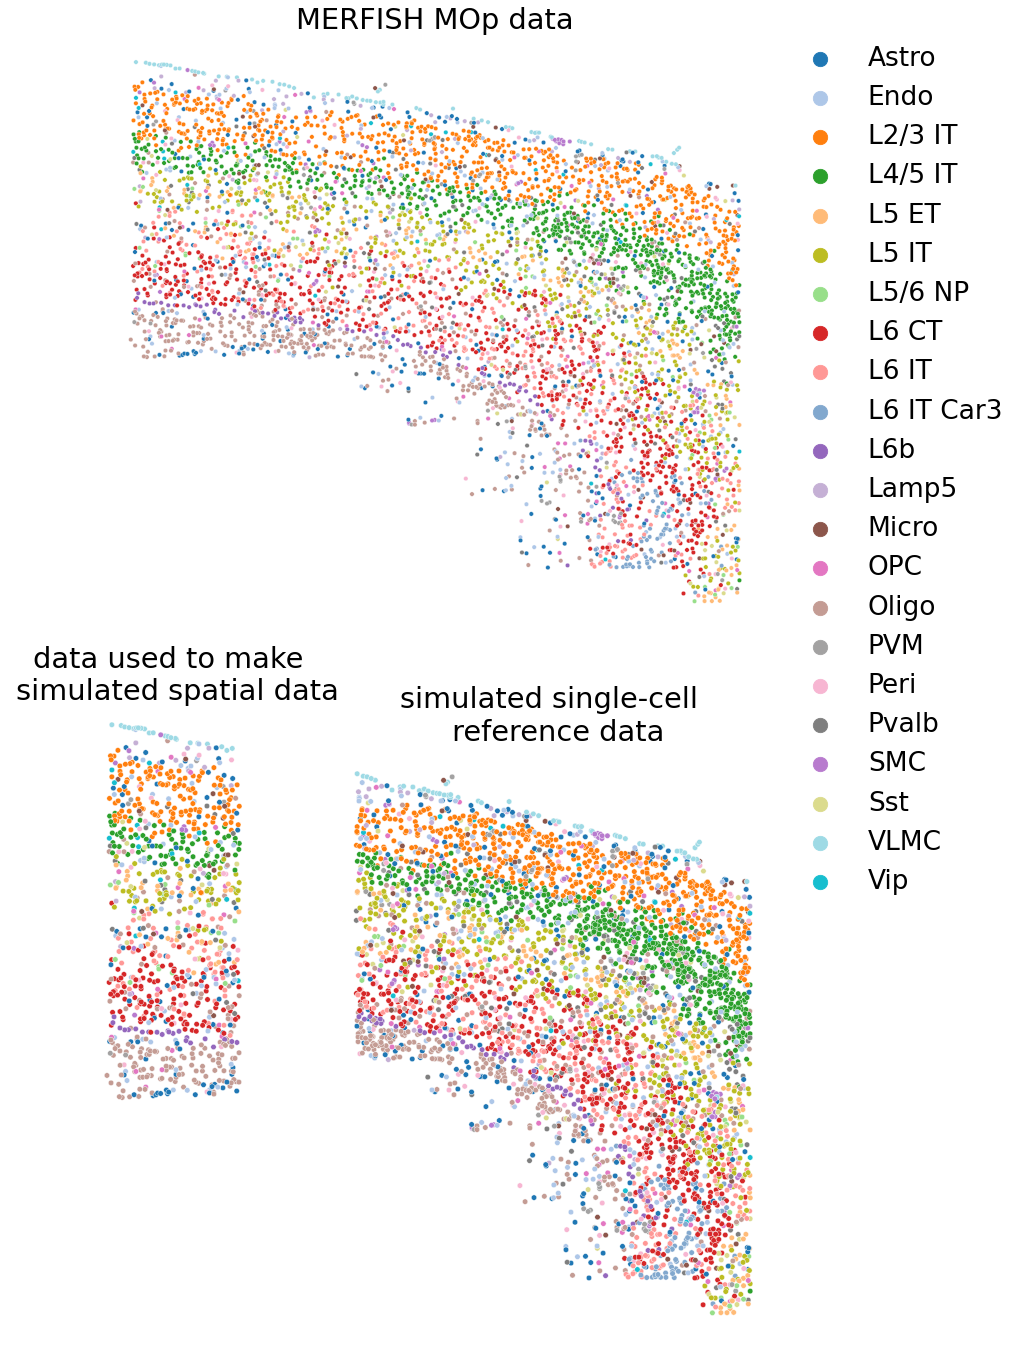

In [150]:
# visualize the data 
sns.set_context('paper',font_scale=3) 
plt.rcParams["legend.markerscale"] = 3

plt.figure(figsize=(12, 24))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(6,4,(13,17))
ax3 = plt.subplot(2,3,(5,6))
ax = [ax1, ax2, ax3]

sns.scatterplot(data=sp_adata.obs, x="X", y="Y", hue='subclass', s = 20, palette = color_dict, ax = ax[0])
ax[0].set_title('MERFISH MOp data')
ax[0].invert_yaxis()
ax[0].axis('off')
ax[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, frameon=False)
sns.scatterplot(data=simulated_sp.obs, x="X", y="Y", hue='subclass', s = 30, palette = color_dict, ax = ax[1], legend = False)
ax[1].set_title('data used to make \n simulated spatial data')
ax[1].invert_yaxis()
ax[1].axis('off')
sns.scatterplot(data=simulated_sc.obs, x="X", y="Y", hue='subclass', s = 30, palette = color_dict, ax = ax[2], legend = False)
ax[2].set_title('simulated single-cell \n reference data')
ax[2].invert_yaxis()
ax[2].axis('off')
plt.show()
plt.close()

In [ ]:
# simulated_sc.write('../Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad')
# simulated_sp.write('../demo_data/MERFISH_MOp_1Kcells.h5ad')

# Learning the gene expression distribution of scRNA-seq reference using score-based model

We use four GPUs to train scRNA-seq reference in parallel.

python ./src/Train_scRef.py \
--ckpt_path ./Ckpts_scRefs/MERFISH_MOp_4Kcells \
--scRef ./Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad \
--cell_class_column subclass \
--down_block_dim 32,64,128,256 \
--sigma_begin 50 \
--sigma_end 0.002 \
--step_lr 3e-7 \
--gpus 0,1,2,3 \

The checkpoints and sampled psuedo-cells will be saved in ./Ckpts_scRefs/MERFISH_MOp_4Kcells, e.g, model_5000.pt, model_5000.h5ad

Conveniently, we provided the pre-trained checkpoint (Ckpts_scRefs/MERFISH_MOp_4Kcells/model_5000.pt) in [here](https://drive.google.com/drive/folders/1PXv_brtr-tXshBVEd_HSPIagjX9oF7Kg), so you can skip this part.

# Generate fake spatial data 

To test the model's robustness, we also add a real scRNA-seq data as reference: a reference scRNA-seq dataset of ~14,000 adult mouse cortical cell taxonomy (the pre-pocessed scRNA-ref (Ckpts_scRefs/VISp/Ref_scRNA_VISp_qc2_2Kgenes.h5ad) can be found [here](https://drive.google.com/drive/folders/1PXv_brtr-tXshBVEd_HSPIagjX9oF7Kg). Detials of the pre-processing of this data can be found in our [tutorial](https://github.com/YangLabHKUST/SpatialScope/blob/master/demos/Mouse-Brain.ipynb))

Because the given cell type label of each cell in MERFISH MOp data and scRNA-seq mouse cortex data are inconsistent, to make the ground truth of simulation study, first we need to preprocess the data to match the cell types.

In [226]:
sp_adata = simulated_sp.copy()
sc_adata = sc.read(os.path.join(SpatialScope_base_path, '../Ckpts_scRefs/VISp/Ref_scRNA_VISp_qc2_2Kgenes.h5ad'))

sp_adata.obs_names_make_unique()
sp_adata.var_names_make_unique()
sc_adata.obs_names_make_unique()
sc_adata.var_names_make_unique()

cell_class_column = 'cell_subclass'
sp_cell_class_column = 'subclass'

if sc_adata.X.max()<30:
    sc_adata.X = np.exp(sc_adata.X) - 1
#     sc.pp.normalize_total(sc_adata, inplace=True)
if sp_adata.X.max()<30:
    sp_adata.X = np.exp(sp_adata.X) - 1

In [227]:
np.unique(sc_adata.obs[cell_class_column])

array(['Astro', 'CR', 'Endo', 'L2/3 IT', 'L4', 'L5 IT', 'L5 NP', 'L5 PT',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Macrophage', 'Meis2', 'Oligo',
       'Peri', 'Pvalb', 'SMC', 'Serpinf1', 'Sncg', 'Sst', 'VLMC', 'Vip'],
      dtype=object)

In [228]:
np.unique(sp_adata.obs[sp_cell_class_column])

array(['Astro', 'Endo', 'L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP',
       'L6 CT', 'L6 IT', 'L6b', 'Lamp5', 'Micro', 'OPC', 'Oligo', 'PVM',
       'Peri', 'Pvalb', 'SMC', 'Sst', 'VLMC', 'Vip'], dtype=object)

In [229]:
sp_adata_ct = np.array(sp_adata.obs[sp_cell_class_column])

# pre-process spatial data 
sp_adata_ct = np.array([_.replace('L4/5 IT', 'L5 IT') for _ in sp_adata_ct])
sp_adata_ct = np.array([_.replace('L5/6 NP', 'L5 NP') for _ in sp_adata_ct])

sp_adata.obs['cell_type'] = sp_adata_ct
sp_cell_class_column = 'cell_type'

# pre-process reference data
sc_adata_ct = np.array(sc_adata.obs[cell_class_column])

sc_adata.obs['cell_type'] = sc_adata_ct
cell_class_column = 'cell_type'

overlap_ct = np.array(list(set(np.unique(sp_adata.obs['cell_type'])) & set(np.unique(sc_adata.obs[cell_class_column]))))

sp_adata =  sp_adata[sp_adata.obs['cell_type'].isin(overlap_ct)].copy()
sc_adata = sc_adata[sc_adata.obs[cell_class_column].isin(overlap_ct)].copy()

# sp_adata.write('../demo_data/MERFISH_MOp_1Kcells.h5ad')

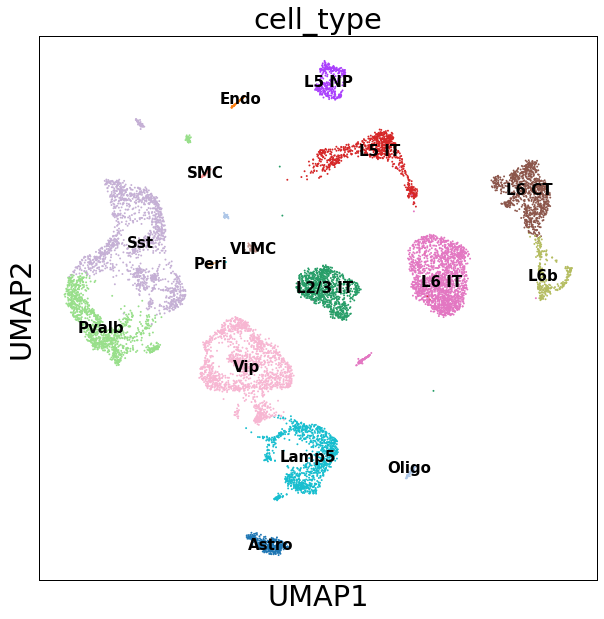

In [155]:
with mpl.rc_context({'figure.figsize': [10, 10],
                 'axes.facecolor': 'white'}):
    sc.pl.umap(sc_adata, color=['cell_type'], size=15,
               color_map = 'RdPu', ncols = 1, legend_loc='on data',
               legend_fontsize=15)
    plt.close()

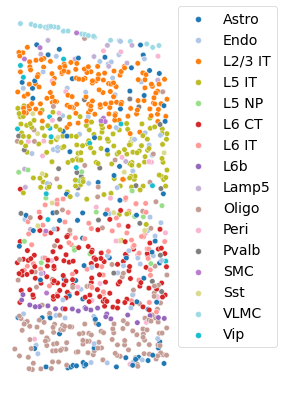

In [161]:
sns.set_context('paper',font_scale=1.6) 
plt.rcParams["legend.markerscale"] = 1

with mpl.rc_context({'figure.figsize': (3, 7)}):
    ax = sns.scatterplot(data=sp_adata.obs, x="X", y="Y", hue='cell_type', s = 30, hue_order = np.unique(sp_adata.obs.cell_type), palette = color_dict)#, legend = False)
    ax.invert_yaxis()
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    ax.axis('off')
    plt.show()
    plt.close()


Now we aggregate the cells on uniform grids to simulate spots.

cell number range: [1 2 3 4 5]
saved simulated spatial data of subsample 130 UMI in /home/xwanaf/bio/multiSlices_SS/mouseOB/SpatialScope/demo_data/simulation/130UMI/spatial.h5ad
saved processed VISp data in /home/xwanaf/bio/multiSlices_SS/mouseOB/SpatialScope/demo_data/simulation/130UMI/processed_VISp.h5ad
cell number range: [1 2 3 4 5]
saved simulated spatial data of subsample 260 UMI in /home/xwanaf/bio/multiSlices_SS/mouseOB/SpatialScope/demo_data/simulation/260UMI/spatial.h5ad
saved processed VISp data in /home/xwanaf/bio/multiSlices_SS/mouseOB/SpatialScope/demo_data/simulation/260UMI/processed_VISp.h5ad
cell number range: [1 2 3 4 5]
saved simulated spatial data of subsample 520 UMI in /home/xwanaf/bio/multiSlices_SS/mouseOB/SpatialScope/demo_data/simulation/520UMI/spatial.h5ad
saved processed VISp data in /home/xwanaf/bio/multiSlices_SS/mouseOB/SpatialScope/demo_data/simulation/520UMI/processed_VISp.h5ad


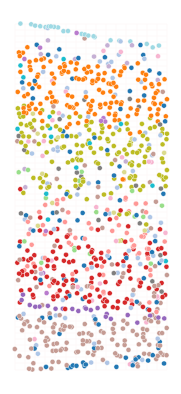

In [230]:
x_min = sp_adata.obs['X'].min()
x_max = sp_adata.obs['X'].max()
y_min = sp_adata.obs['Y'].min()
y_max = sp_adata.obs['Y'].max()

num_x = 16
num_y = 58

spatial_adata =  sp_adata.copy()

# make grid 
x_seg = np.linspace(x_min, x_max, num_x)
y_seg = np.linspace(y_min, y_max, num_y)

with mpl.rc_context({'figure.figsize': (3, 7)}):
    ax = sns.scatterplot(data=spatial_adata.obs, x="X", y="Y", hue=sp_cell_class_column, s = 25, palette = color_dict, legend = False)
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .1, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .1, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')
    
for sample_UMI in [130, 260, 520]:
    spatial_adata =  sp_adata.copy()
    
    # create fake spatial data with 'cell_locations' in uns (We assume the truth cell number in each fake spot is known in simulation study, thus skip "Nuclei segmentation" step in SpatialScope)
    spatial_adata = add_spot_label(spatial_adata, x_seg, y_seg)
    print(f'cell number range: {np.unique(generated_spot_adata.obs.cell_nums)}')
    generated_spot_adata = generate_spot_adata_func(spatial_adata, sample_UMI = sample_UMI)

    temp_obs = rename_cell_locations_obs(spatial_adata)
    generated_spot_adata.uns['cell_locations'] = temp_obs

    # filter spot that UMI counts smaller than 20
    generated_spot_adata_filtered = generated_spot_adata.copy()[~(generated_spot_adata.X.sum(1) < 20)]

    index = ~generated_spot_adata.uns['cell_locations']['spot_index_int'].isin(np.where(generated_spot_adata.X.sum(1) < 20)[0])
    generated_spot_adata_filtered.uns['cell_locations'] = generated_spot_adata.uns['cell_locations'][index].copy()


    # save data 
    save_data_dir = os.path.join(SpatialScope_base_path, f'demo_data/simulation/{int(sample_UMI)}UMI')
    ## spatial
    generated_spot_adata_filtered.obs = generated_spot_adata_filtered.obs.rename(columns = {'X':'x', 'Y':'y'})
    generated_spot_adata_filtered.obsm['spatial'] = generated_spot_adata_filtered.obs[['x','y']].values
    cell_locations = generated_spot_adata_filtered.uns['cell_locations'].copy()
    cell_locations = cell_locations.rename(columns = {'X':'x', 'Y':'y'})
    generated_spot_adata_filtered.uns['cell_locations'] = cell_locations
    generated_spot_adata_filtered.obs_names_make_unique()
    generated_spot_adata_filtered.var_names_make_unique()
    save_sp_dir = os.path.join(save_data_dir, 'spatial.h5ad')
    print(f'saved simulated spatial data of subsample {sample_UMI} UMI in {save_sp_dir}')
#     generated_spot_adata_filtered.write(save_sp_dir)


    # save processed VISp data
    save_sc_dir = os.path.join(save_data_dir, 'processed_VISp.h5ad')
    print(f'saved processed VISp data in {save_sc_dir}')
    sc_adata.write(save_sc_dir)

# RUN SpatialScope 

## Step1: Nuclei segmentation 
In simulation study, we assume that we know the ground truth cell number in each spot and the cell number already saved in .uns['cell_locations']. Therefore we skip this step.

## Step2: Cell type identification

```
declare -a arr=('130UMI' '260UMI' '520UMI')

for i in "${arr[@]}"

do

python ./src/Cell_Type_Identification.py --tissue $i --out_dir ./output  --ST_Data ./demo_data/simulation/$i/spatial.h5ad --SC_Data ./Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad --cell_class_column cell_subclass --hs_ST --UMI_min_sigma 100

done


for i in "${arr[@]}"

do

python ./src/Cell_Type_Identification.py --tissue $i"_VISp" --out_dir ./output  --ST_Data ./demo_data/simulation/$i/spatial.h5ad --SC_Data ./demo_data/simulation/$i/processed_VISp.h5ad --cell_class_column cell_type --hs_ST --UMI_min_sigma 100

done
```

## Step3: Gene expression decomposition


```
declare -a arr=('130UMI' '260UMI' '520UMI')

for i in "${arr[@]}"

do

python ./src/Decomposition.py \
--tissue $i \
--out_dir ./output \
--SC_Data ./Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad \
--cell_class_column subclass \
--ckpt_path ./Ckpts_scRefs/MERFISH_MOp_4Kcells/model_5000.pt \
--replicates 5 \
--gpu 5,6,7,8 \

done

for i in "${arr[@]}"

do

python ./src/Decomposition.py \
--tissue $i"_VISp" \
--out_dir ./output \
--SC_Data ./Ckpts_scRefs/VISp/Ref_scRNA_VISp_qc2_2Kgenes.h5ad \
--cell_class_column cell_subclass \
--ckpt_path ./Ckpts_scRefs/VISp/model_5000.pt \
--replicates 5 \
--gpu 5,6,7,8 \

done
```

# Cell type identification results 

load results from /home/share/xwanaf/sour_sep/revision/data/benchmarking_tutorial/130UMI


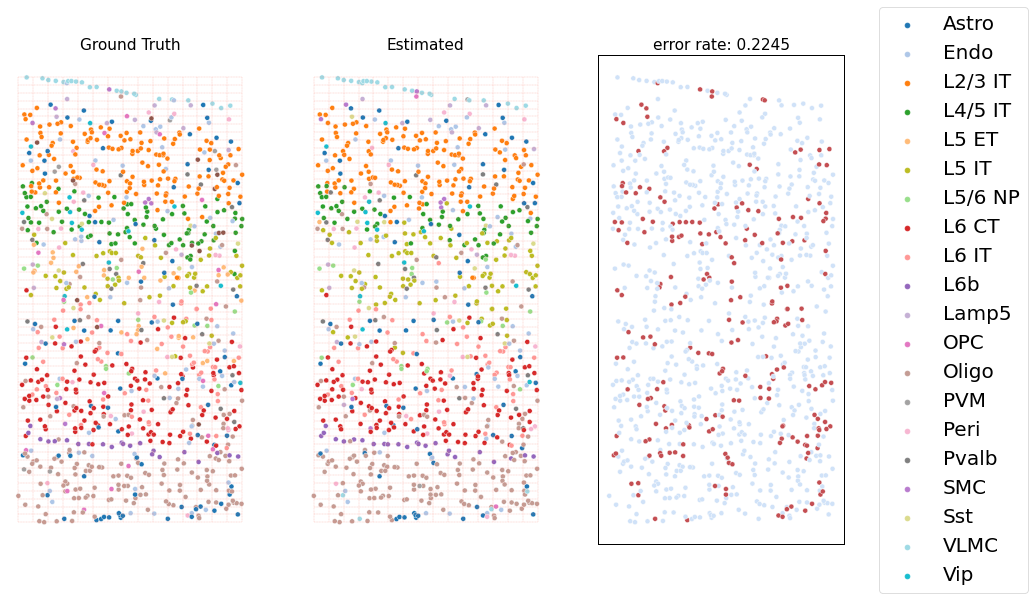

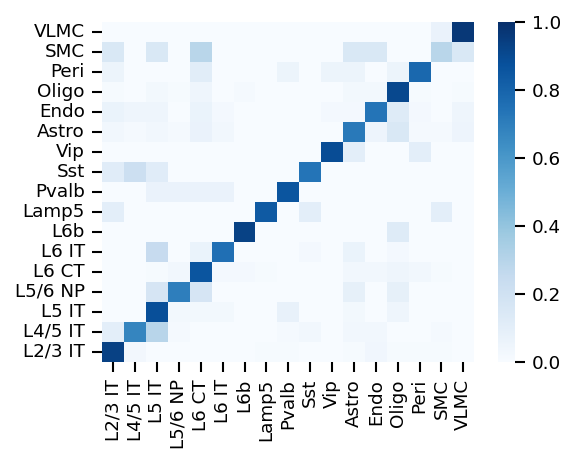

load results from /home/share/xwanaf/sour_sep/revision/data/benchmarking_tutorial/260UMI


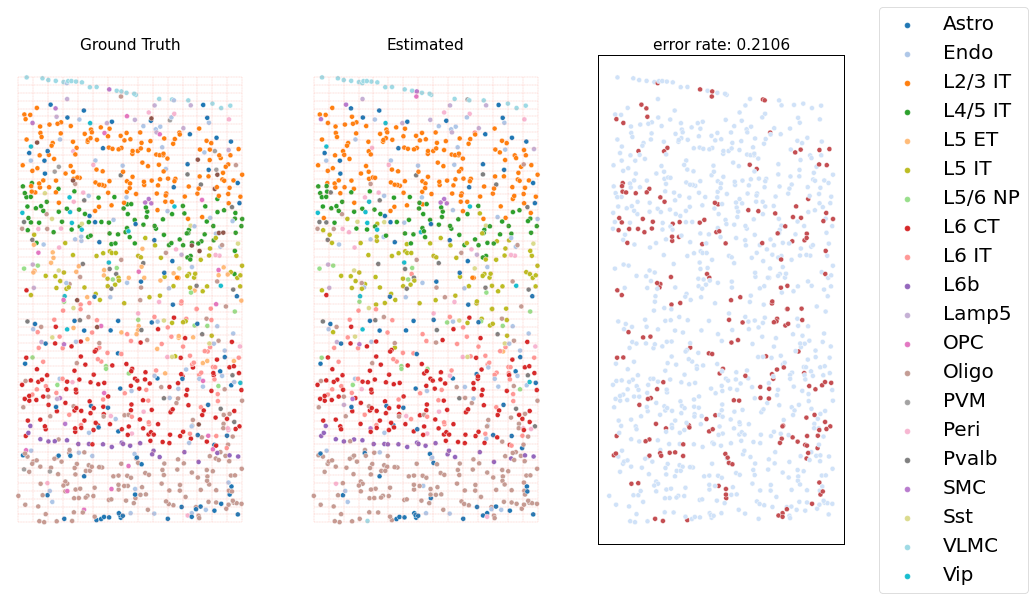

load results from /home/share/xwanaf/sour_sep/revision/data/benchmarking_tutorial/520UMI


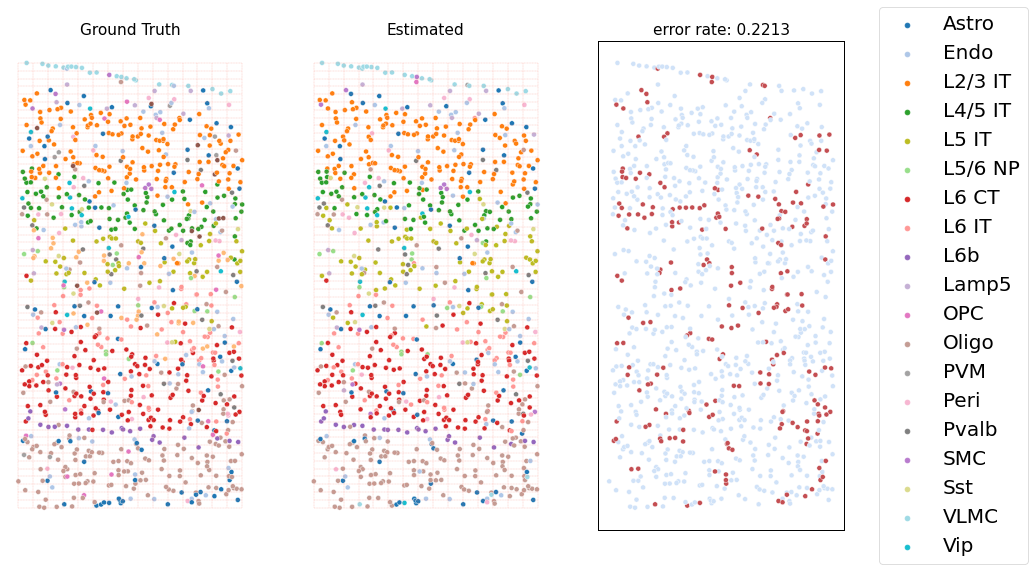

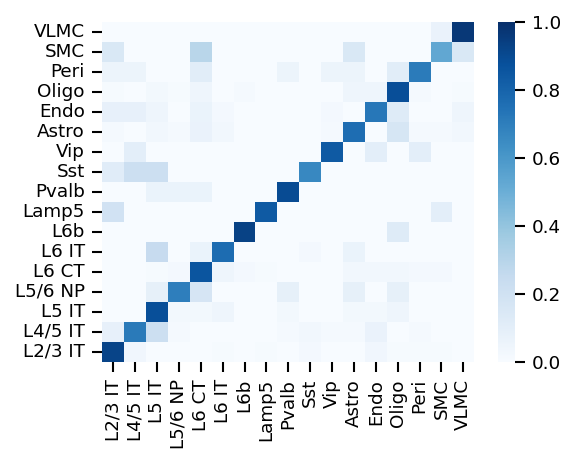

In [377]:
sp_adata = sc.read('../demo_data/MERFISH_MOp_1Kcells.h5ad')
sp_adata.obs_names_make_unique()
sp_adata.var_names_make_unique()

sp_cell_class_column = 'subclass'

if sp_adata.X.max()<30:
    sp_adata.X = np.exp(sp_adata.X) - 1
    
sc.pp.log1p(sp_adata)

# make grid
num_x = 16
num_y = 58

x_min = sp_adata.obs['X'].min()
x_max = sp_adata.obs['X'].max()
y_min = sp_adata.obs['Y'].min()
y_max = sp_adata.obs['Y'].max()

x_seg = np.linspace(x_min, x_max, num_x)
y_seg = np.linspace(y_min, y_max, num_y)

Glutamatergic = ['L2/3 IT', 'L4/5 IT', 'L5 ET', 'L5 IT', 'L5/6 NP', 'L6 CT', 'L6 IT', 'L6b']
GABAergic = ['Lamp5', 'Pvalb', 'Sst', 'Vip']
Non_neuronal = ['Astro', 'Endo', 'Oligo', 'OPC', 'Peri', 'SMC', 'VLMC', 'Micro', 'PVM']


# load results and calculate error rate 
out_dir = '/home/share/xwanaf/sour_sep/revision/data/benchmarking_tutorial'

for tissue in ['130UMI', '260UMI', '520UMI']:
    data_path = os.path.join(out_dir, tissue)
    

    print(f'load results from {data_path}')
    cell_locations = pd.read_csv(os.path.join(data_path, 'CellTypeLabel_nu10.csv'))
    estimated = np.array(cell_locations['discrete_label_ct'])
    tl = np.array(cell_locations['subclass'])
    error_index = tl != estimated
    cell_locations['error'] = (error_index).astype(int) 
    error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
    # print(f'error rate: {error_rate}')


    # plot results
#     fig, ax = plt.subplots(1,4, figsize = (30,9), gridspec_kw = {'width_ratios': [1.5,1.5,1.5,6]})
    sns.set_context('paper',font_scale=1.6)
    fig, ax = plt.subplots(1,3, figsize = (15,9))

    sns.scatterplot(data=sp_adata.obs, x="X", y="Y", hue='subclass', s = 25, palette = color_dict, legend = False, ax = ax[0])
    ax[0].invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax[0].plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .3, alpha = 0.8)
    for i in range(y_seg.shape[0]):    
        ax[0].plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .3, alpha = 0.8)
    #     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[0].set_title('Ground Truth')
    ax[0].axis('off')

    sns.scatterplot(data=cell_locations, x="x", y="y", hue='discrete_label_ct', hue_order = np.unique(cell_locations.discrete_label_ct), s = 25, palette = color_dict, ax = ax[1])
    ax[1].invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax[1].plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .3, alpha = 0.8)
    for i in range(y_seg.shape[0]):    
        ax[1].plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .3, alpha = 0.8)
        ax[1].legend(loc='center left', bbox_to_anchor=(2.3, 0.5), fontsize="20")
    ax[1].set_title(f'Estimated')
    ax[1].axis('off')

    sns.scatterplot(data=cell_locations, x="x", y="y", hue="error", s = 25, palette = ['#D0E2F8', '#c44e52'], ax = ax[2])
    ax[2].invert_yaxis()
    # ax.axis('off')
    ax[2].set_title('error rate: {:.4f}'.format(error_rate))
    ax[2].get_yaxis().set_visible(False)
    ax[2].get_xaxis().set_visible(False)
    ax[2].get_legend().remove()
    plt.show()
    plt.close()
    

    labels = np.array(Glutamatergic + GABAergic + Non_neuronal)
    labels = labels[np.isin(labels, np.unique(np.array(cell_locations['subclass'])))]

    from sklearn.metrics import confusion_matrix
    con_mtx_GT = confusion_matrix(np.array(cell_locations['subclass']), np.array(cell_locations['subclass']), labels=labels)
    con_mtx_SS = confusion_matrix(np.array(cell_locations['subclass']), np.array(cell_locations['discrete_label_ct']), labels=labels)
    
    sns.set_context('paper',font_scale=1) 
    fig, ax = plt.subplots(1,1, figsize = (4,3), dpi = 150)
    vis_df = pd.DataFrame(data = np.log2(con_mtx_SS / con_mtx_SS.sum(1)[:,None] + 1), index = labels, columns = labels)
    sns.heatmap(vis_df, cmap = sns.color_palette("Blues", as_cmap=True), ax = ax, vmin = 0, vmax = np.log2(2))
    ax.invert_yaxis()
    # ax.axis('off')
    plt.show()
    plt.close()


# Gene expression decomposition results 

In [374]:
def ScaleData(df,perc=0.01):
    tmp = df.values
    tmp = np.clip(tmp,np.quantile(tmp,perc),np.quantile(tmp,1-perc))
    tmp = (tmp - tmp.min()) / (tmp.max() - tmp.min())
    return tmp

## Calculate cosine similarity between decomposed gene expression and ground truth along marker genes and each cell

In [438]:
vis_genes = ['CUX2', 'RSPO1', 'FEZF2','SYT6']
cos_genes_df = pd.DataFrame(index = {'130UMI', '260UMI', '520UMI'}, columns = vis_genes)
cos_cells_df = pd.DataFrame(index = cell_locations.index, columns = {'130UMI', '260UMI', '520UMI', '130UMI_VISp', '260UMI_VISp', '520UMI_VISp'})
cos_cells_df = pd.DataFrame(columns = {'cosine similarity', 'subsample', 'reference'})
    
gt_spot_exp = []
SpatialScope_exp = []
gt_cells_exp = sp_adata.copy()
gt_cells_exp.obs = gt_cells_exp.obs.rename(columns = {'X':'x', 'Y':'y'})
gt_cells_exp.var.index = [_.upper() for _ in gt_cells_exp.var.index]

for tissue in ['130UMI', '260UMI', '520UMI']:
    data_path = os.path.join(out_dir, tissue)
    fake_spots_data = sc.read(os.path.join(data_path, 'sp_adata.h5ad'))
    fake_spots_data.var.index = [_.upper() for _ in fake_spots_data.var.index]
    gt_spot_exp.append(fake_spots_data)
    generated_cells = sc.read(os.path.join(data_path, 'generated_cells_spot0_599.h5ad'))
    SpatialScope_exp.append(generated_cells)
    if generated_cells.X.max()>=30:
        sc.pp.log1p(generated_cells)

    sp_adata_SS = sp_adata.copy()
    sp_adata_SS = sp_adata_SS[generated_cells.obs.index]
    sp_adata_SS.var.index = [_.upper() for _ in sp_adata_SS.var.index]
    generated_cells.var.index = [_.upper() for _ in generated_cells.var.index]


    overlaped_genes = np.array(list(set(sp_adata_SS.var.index)&set(generated_cells.var.index)))
    sp_adata_SS = sp_adata_SS.copy()[:, overlaped_genes]
    generated_cells = generated_cells.copy()[:, overlaped_genes]

    reorder_index = reorder(sp_adata_SS, generated_cells, spot_id_name = 'spot_index', cell_type_colname = 'discrete_label_ct')
    generated_cells.X = generated_cells.X[reorder_index]
    
    error_index = np.array(generated_cells.obs['subclass']) != np.array(generated_cells.obs['discrete_label_ct'])
    
    temp = pd.DataFrame()
    temp['cosine similarity'] = list(np.diag(cosine_similarity(sp_adata_SS.X.copy(), generated_cells.X.copy())))
    temp['subsample'] = [tissue] * sp_adata_SS.shape[0]
    temp['reference'] = ['paired'] * sp_adata_SS.shape[0]
    temp['error'] = (error_index).astype(int)
    cos_cells_df = pd.concat([cos_cells_df, temp], axis = 0)
    
    SS_ref = sp_adata_SS.copy()
    SS_gene = generated_cells.copy()

    for gene in vis_genes:
        SS_ref.obs[gene] = ScaleData(SS_ref.to_df()[gene])
        SS_gene.obs[gene] = ScaleData(SS_gene.to_df()[gene])
        cos_genes_df.loc[tissue, gene] = cosine_similarity(SS_ref.obs[gene][None,:], SS_gene.obs[gene][None,:]).item()
        
    
for tissue in ['130UMI_VISp', '260UMI_VISp', '520UMI_VISp']:
    data_path = os.path.join(out_dir, tissue)
    generated_cells = sc.read(os.path.join(data_path, 'generated_cells_spot0_599.h5ad'))
    SpatialScope_exp.append(generated_cells)
    if generated_cells.X.max()>=30:
        sc.pp.log1p(generated_cells)

    sp_adata_SS = sp_adata.copy()
    sp_adata_SS = sp_adata_SS[generated_cells.obs.index]
    sp_adata_SS.var.index = [_.upper() for _ in sp_adata_SS.var.index]
    generated_cells.var.index = [_.upper() for _ in generated_cells.var.index]


    overlaped_genes = np.array(list(set(sp_adata_SS.var.index)&set(generated_cells.var.index)))
    sp_adata_SS = sp_adata_SS.copy()[:, overlaped_genes]
    generated_cells = generated_cells.copy()[:, overlaped_genes]

    reorder_index = reorder(sp_adata_SS, generated_cells, spot_id_name = 'spot_index', cell_type_colname = 'discrete_label_ct')
    generated_cells.X = generated_cells.X[reorder_index]
    
    error_index = np.array(generated_cells.obs['cell_type']) != np.array(generated_cells.obs['discrete_label_ct'])
    
    temp = pd.DataFrame()
    temp['cosine similarity'] = list(np.diag(cosine_similarity(sp_adata_SS.X.copy(), generated_cells.X.copy())))
    temp['subsample'] = [tissue.split('_')[0]] * sp_adata_SS.shape[0]
    temp['reference'] = ['VISp'] * sp_adata_SS.shape[0]
    temp['error'] = (error_index).astype(int)
    cos_cells_df = pd.concat([cos_cells_df, temp], axis = 0)
    
    

In [439]:
cos_cells_df

reference cosine similarity subsample  error
0      paired          0.974187    130UMI    0.0
1      paired           0.87713    130UMI    0.0
2      paired          0.806262    130UMI    0.0
3      paired          0.418215    130UMI    1.0
4      paired          0.429415    130UMI    1.0
..        ...               ...       ...    ...
935      VISp          0.734508    520UMI    0.0
936      VISp           0.79722    520UMI    0.0
937      VISp          0.842825    520UMI    0.0
938      VISp          0.744422    520UMI    0.0
939      VISp          0.859559    520UMI    0.0

[5640 rows x 4 columns]

In [447]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2.5) 
fig, ax = plt.subplots(1,2, figsize = (20, 7))
plt.subplots_adjust(hspace = 0.5)


sns.barplot(x="subsample", y="cosine similarity", hue="reference",data=cos_cells_df, palette="Set3", ax = ax[0])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_ylim(0.35,1.05)
ax[0].get_legend().remove()
ax[0].set_ylabel('')
ax[0].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax[0].set_xlabel('all cells')

sns.barplot(x="subsample", y="cosine similarity", hue="reference",data=cos_cells_df[cos_cells_df['error'] == 0], palette="Set3", ax = ax[1])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_ylim(0.35,1.05)
ax[1].set_ylabel('')
ax[1].set_yticklabels([])
ax[1].set_yticks([0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax[1].legend(loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize="25")
ax[1].set_xlabel('cells with correctly \n estimated cell type label')

fig.text(0.08, 0.5, 'Cosine Similarity', va='center', rotation='vertical')
plt.show()


In [448]:
cos_genes_df

CUX2     RSPO1     FEZF2      SYT6
260UMI  0.897183  0.760871  0.833311  0.831317
130UMI  0.880826  0.656237  0.752168  0.811572
520UMI  0.908756  0.779119  0.841604  0.826382

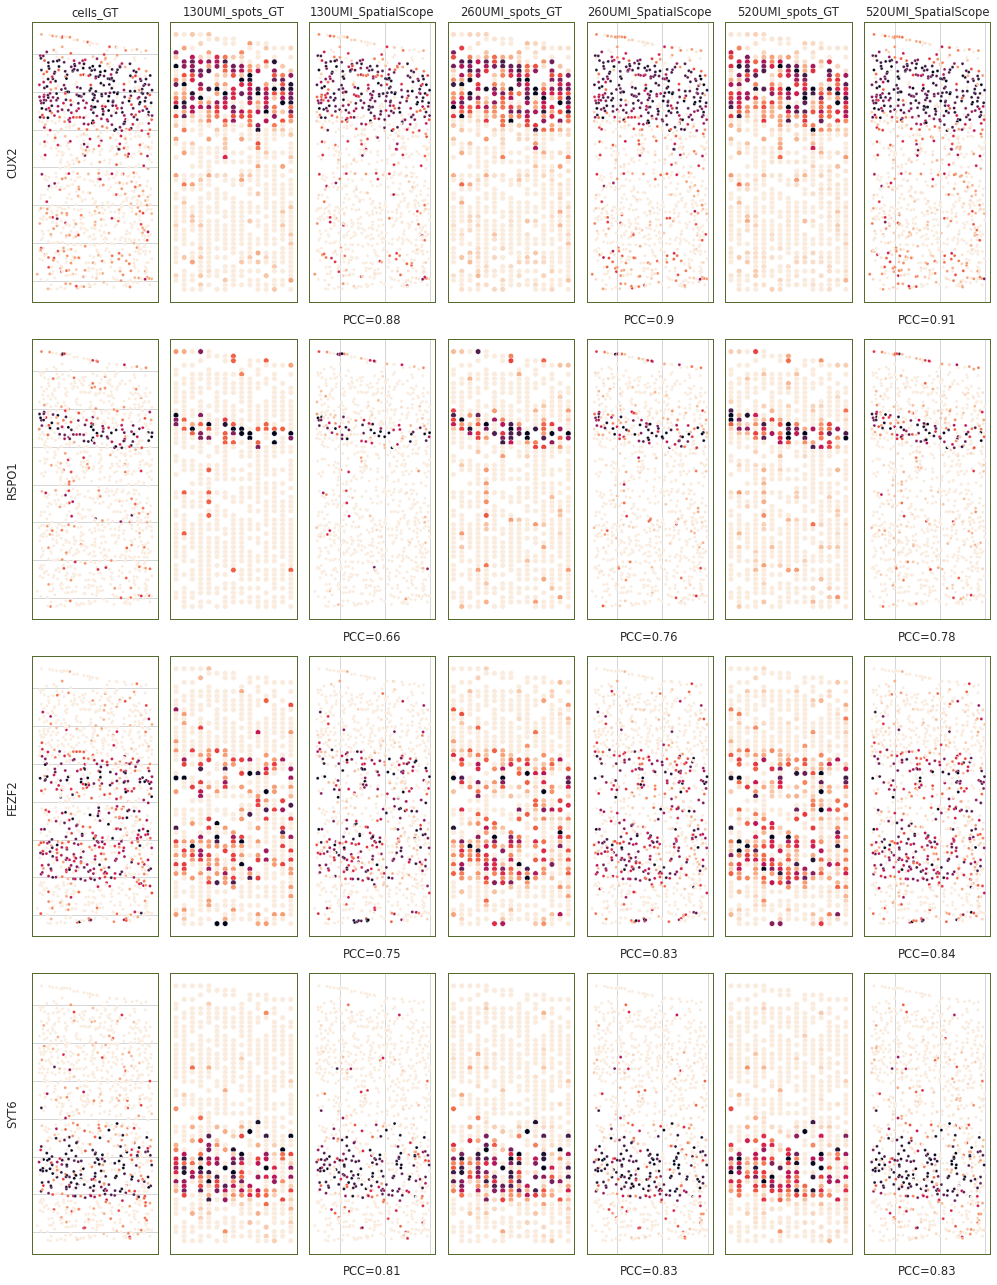

In [449]:
vis_genes = ['CUX2', 'RSPO1', 'FEZF2','SYT6'] 
    
subsampled_UMI = ['cells_GT', '130UMI_spots_GT', '130UMI_SpatialScope', '260UMI_spots_GT', '260UMI_SpatialScope', '520UMI_spots_GT', '520UMI_SpatialScope']
sns.set_context('paper',font_scale=1.2) 
fig, ax = plt.subplots(len(vis_genes),len(subsampled_UMI), figsize = (2 * len(subsampled_UMI),4.5 * len(vis_genes)))
for j, gene in enumerate(vis_genes):
    for i, df_vis in enumerate([gt_cells_exp, gt_spot_exp[0], SpatialScope_exp[0], gt_spot_exp[1], SpatialScope_exp[1],gt_spot_exp[2], SpatialScope_exp[2]]): 
        for gene_column in vis_genes:
            df_vis.obs[gene_column] = ScaleData(df_vis.to_df()[gene_column])

        if 'spots' in subsampled_UMI[i]:
            s = 30
        else:
            s = 9
        sns.scatterplot(data=df_vis.obs, x="x", y="y", hue=vis_genes[j], s = s, ax = ax[j,i], palette = 'rocket_r', legend = False)
        for _,ax_s in ax[j, i].spines.items():
            ax_s.set_linewidth(1)
            ax_s.set_color('darkolivegreen')
        ax[j, i].invert_yaxis()
        if j == 0:
            ax[j, i].set_title(subsampled_UMI[i])
        
        if subsampled_UMI[i] == 'cells_GT':
            ax[j,i].set(yticklabels=[]) 
            ax[j,i].tick_params(left=False)
            ax[j,i].set_ylabel(gene)
        else:
            ax[j,i].set(yticklabels=[]) 
            ax[j,i].tick_params(left=False)
            ax[j, i].get_yaxis().set_visible(False)
            
            
        if 'SpatialScope' in subsampled_UMI[i]:
            ax[j,i].set(xticklabels=[]) 
            ax[j,i].tick_params(bottom=False)
            ax[j,i].set_xlabel('PCC={}'.format(round(cos_genes_df.loc[subsampled_UMI[i].split('_')[0], gene], 2)))
        else:
            ax[j, i].get_xaxis().set_visible(False)

fig.tight_layout()


## UMAP visualization gene expression decomposition results

In [456]:
tissue = '260UMI'
data_path = os.path.join(out_dir, tissue)
fake_spots_data = sc.read(os.path.join(data_path, 'sp_adata.h5ad'))
generated_cells = sc.read(os.path.join(data_path, 'generated_cells_spot0_599.h5ad'))
SpatialScope_exp.append(generated_cells)
if generated_cells.X.max()>=30:
    sc.pp.log1p(generated_cells)

sp_adata_SS = sp_adata.copy()
sp_adata_SS = sp_adata_SS[generated_cells.obs.index]
sp_adata_SS.var.index = [_.upper() for _ in sp_adata_SS.var.index]
generated_cells.var.index = [_.upper() for _ in generated_cells.var.index]


overlaped_genes = np.array(list(set(sp_adata_SS.var.index)&set(generated_cells.var.index)))
sp_adata_SS = sp_adata_SS.copy()[:, overlaped_genes]
generated_cells = generated_cells.copy()[:, overlaped_genes]

reorder_index = reorder(sp_adata_SS, generated_cells, spot_id_name = 'spot_index', cell_type_colname = 'discrete_label_ct')
generated_cells.X = generated_cells.X[reorder_index]
    

In [451]:
search_spot_adata = generated_cells.copy()
cos = np.diag(cosine_similarity(sp_adata_SS.X.copy(), search_spot_adata.X.copy()))
for spot_id in np.unique(search_spot_adata.obs['spot_index']):
    index = np.array(search_spot_adata.obs['spot_index'] == spot_id)
    cond1 = (cos[index] < 0.88).sum() == 0
    cond2 = index.sum() > 1
    vals, counts = np.unique(np.array(search_spot_adata[index].obs['cell_type']), return_counts = True)
    vals1, counts1 = np.unique(np.array(search_spot_adata[index].obs['discrete_label_ct']), return_counts = True)
    cond3 = np.array_equal(vals, vals1)
    cond4 = np.array_equal(counts, counts1)
    cond5 = len(vals) > 1
    if cond1 & cond2 & cond3 & cond4 & cond5:
        print(spot_id)

spot_103
spot_14
spot_207
spot_308
spot_344
spot_378
spot_409
spot_467
spot_499
spot_506
spot_530
spot_81
spot_96
spot_98


In [458]:
#469, 550
cell_locations = fake_spots_data.uns['cell_locations'].copy()
ispot = 'spot_' + str(103)

with mpl.rc_context({'figure.figsize': (4, 4)}):
    ax = sns.scatterplot(data=cell_locations[cell_locations['spot_index'] == ispot], x="x", y="y", hue='subclass', s = 5000, palette = color_dict, legend = False)
    ax.invert_yaxis()
    ax.axis('off')

In [481]:
# match decomposed cells and true cells
ss_cells = generated_cells.copy()
cells = sp_adata.copy()
cells = cells[ss_cells.obs.index]
cells.var.index = [_.upper() for _ in cells.var.index]
cells.obs['spot_index'] = ss_cells.obs['spot_index'].copy()
overlaped_genes = np.array(list(set(ss_cells.var.index)&set(cells.var.index)))
ss_cells = ss_cells.copy()[:, overlaped_genes]
cells = cells.copy()[:, overlaped_genes]

##combine single-cell reference data and all the cells for UMAP
# ad_sc = sc.read('../Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad')
ad_sc = sc.read('/home/share/xiaojs/spatial/sour_sep/simu_merfish/MERFISH_MOp_4Kcells.h5ad')
ad_sc.var.index = [_.upper() for _ in ad_sc.var.index]
ad_sc = ad_sc[:, overlaped_genes]
if ad_sc.X.max()>30:
    print(f'Maximum value: {ad_sc.X.max()}, need to run log1p')
    sc.pp.log1p(ad_sc)
    
for cells in [ss_cells, cells]:
    if cells.X.max()<30:
        print(f'Maximum value: {cells.X.max()}, need to run exp')
        cells.X = np.exp(cells.X)-1
        print(f'Maximum value: {cells.X.max()}')
        
ss_cells_intest = ss_cells[cells.obs.spot_index==ispot]
cells_intest = cells[cells.obs.spot_index==ispot]

sc.pp.log1p(ss_cells_intest)
sc.pp.log1p(cells_intest)

pcs = ad_sc.varm['PCs']
cells_intest.obsm['X_pca'] = (cells_intest.X - ad_sc.X.mean(0)) @ pcs
cells_intest.varm['PCs'] = pcs
ss_cells_intest.obsm['X_pca'] = (ss_cells_intest.X - ad_sc.X.mean(0)) @ pcs
ss_cells_intest.varm['PCs'] = pcs


adata_all = ad_sc.concatenate(cells_intest)
adata_all = adata_all.concatenate(ss_cells_intest)
adata_all.varm['PCs'] = pcs
adata_all.raw = adata_all

n_cells = cells_intest.shape[0]
n_cells_ss = ss_cells_intest.shape[0]

sc.pp.neighbors(adata_all, metric = 'cosine',n_neighbors=15, n_pcs=30)
sc.tl.umap(adata_all, min_dist = 0.5, spread = 1, maxiter = 100, random_state=0)

Maximum value: 5.202021598815918, need to run exp
Maximum value: 180.63906860351562
Maximum value: 5.041958808898926, need to run exp
Maximum value: 153.7729034423828
(4192, 254)


In [482]:
adata_all

AnnData object with n_obs × n_vars = 4192 × 254
    obs: 'sample_id', 'slice_id', 'class_label', 'subclass', 'label', 'X', 'Y', 'n_counts', 'spot_index', 'batch', 'x', 'y', 'cell_type', 'spot_index_int', 'spot_X', 'spot_Y', 'cell_nums', 'cell_index', 'discrete_label', 'discrete_label_ct'
    var: 'n_cells-0', 'Marker-1-0'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [483]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [484]:
fig, ax = plt.subplots(1,1,figsize = (6,6),dpi = 100)
sc.pl.umap(adata_all, color=['subclass'], size=15,
               color_map = 'RdPu', ncols = 1, na_in_legend=False, legend_loc='on data',
               legend_fontsize=10,title='',palette=color_dict,ax=ax,frameon=False)
plt.show()  

In [489]:
df_plot

x          y  size  \
0     12.360665  -1.900022   1.0   
1     18.553503   9.974305   1.0   
2      5.402404   0.182596   1.0   
3      2.683804  10.746480   1.0   
4      9.204082   1.691357   1.0   
...         ...        ...   ...   
4187  10.073549  -2.437423   1.0   
4188  13.253314   2.146279  12.0   
4189   3.276021  10.847384  12.0   
4190  12.814904   2.091478   4.0   
4191   2.749079  11.113776   4.0   

                                                  color  
0     All cells from the single-cell reference data ...  
1     All cells from the single-cell reference data ...  
2     All cells from the single-cell reference data ...  
3     All cells from the single-cell reference data ...  
4     All cells from the single-cell reference data ...  
...                                                 ...  
4187  All cells from the single-cell reference data ...  
4188              Selected scRNA-seq Cells from spatial  
4189              Selected scRNA-seq Cells from spatial  
4190                    Generated Cells by SpatialScope  
4191  All cells from the single-cell reference data ...  

[4192 rows x 4 columns]

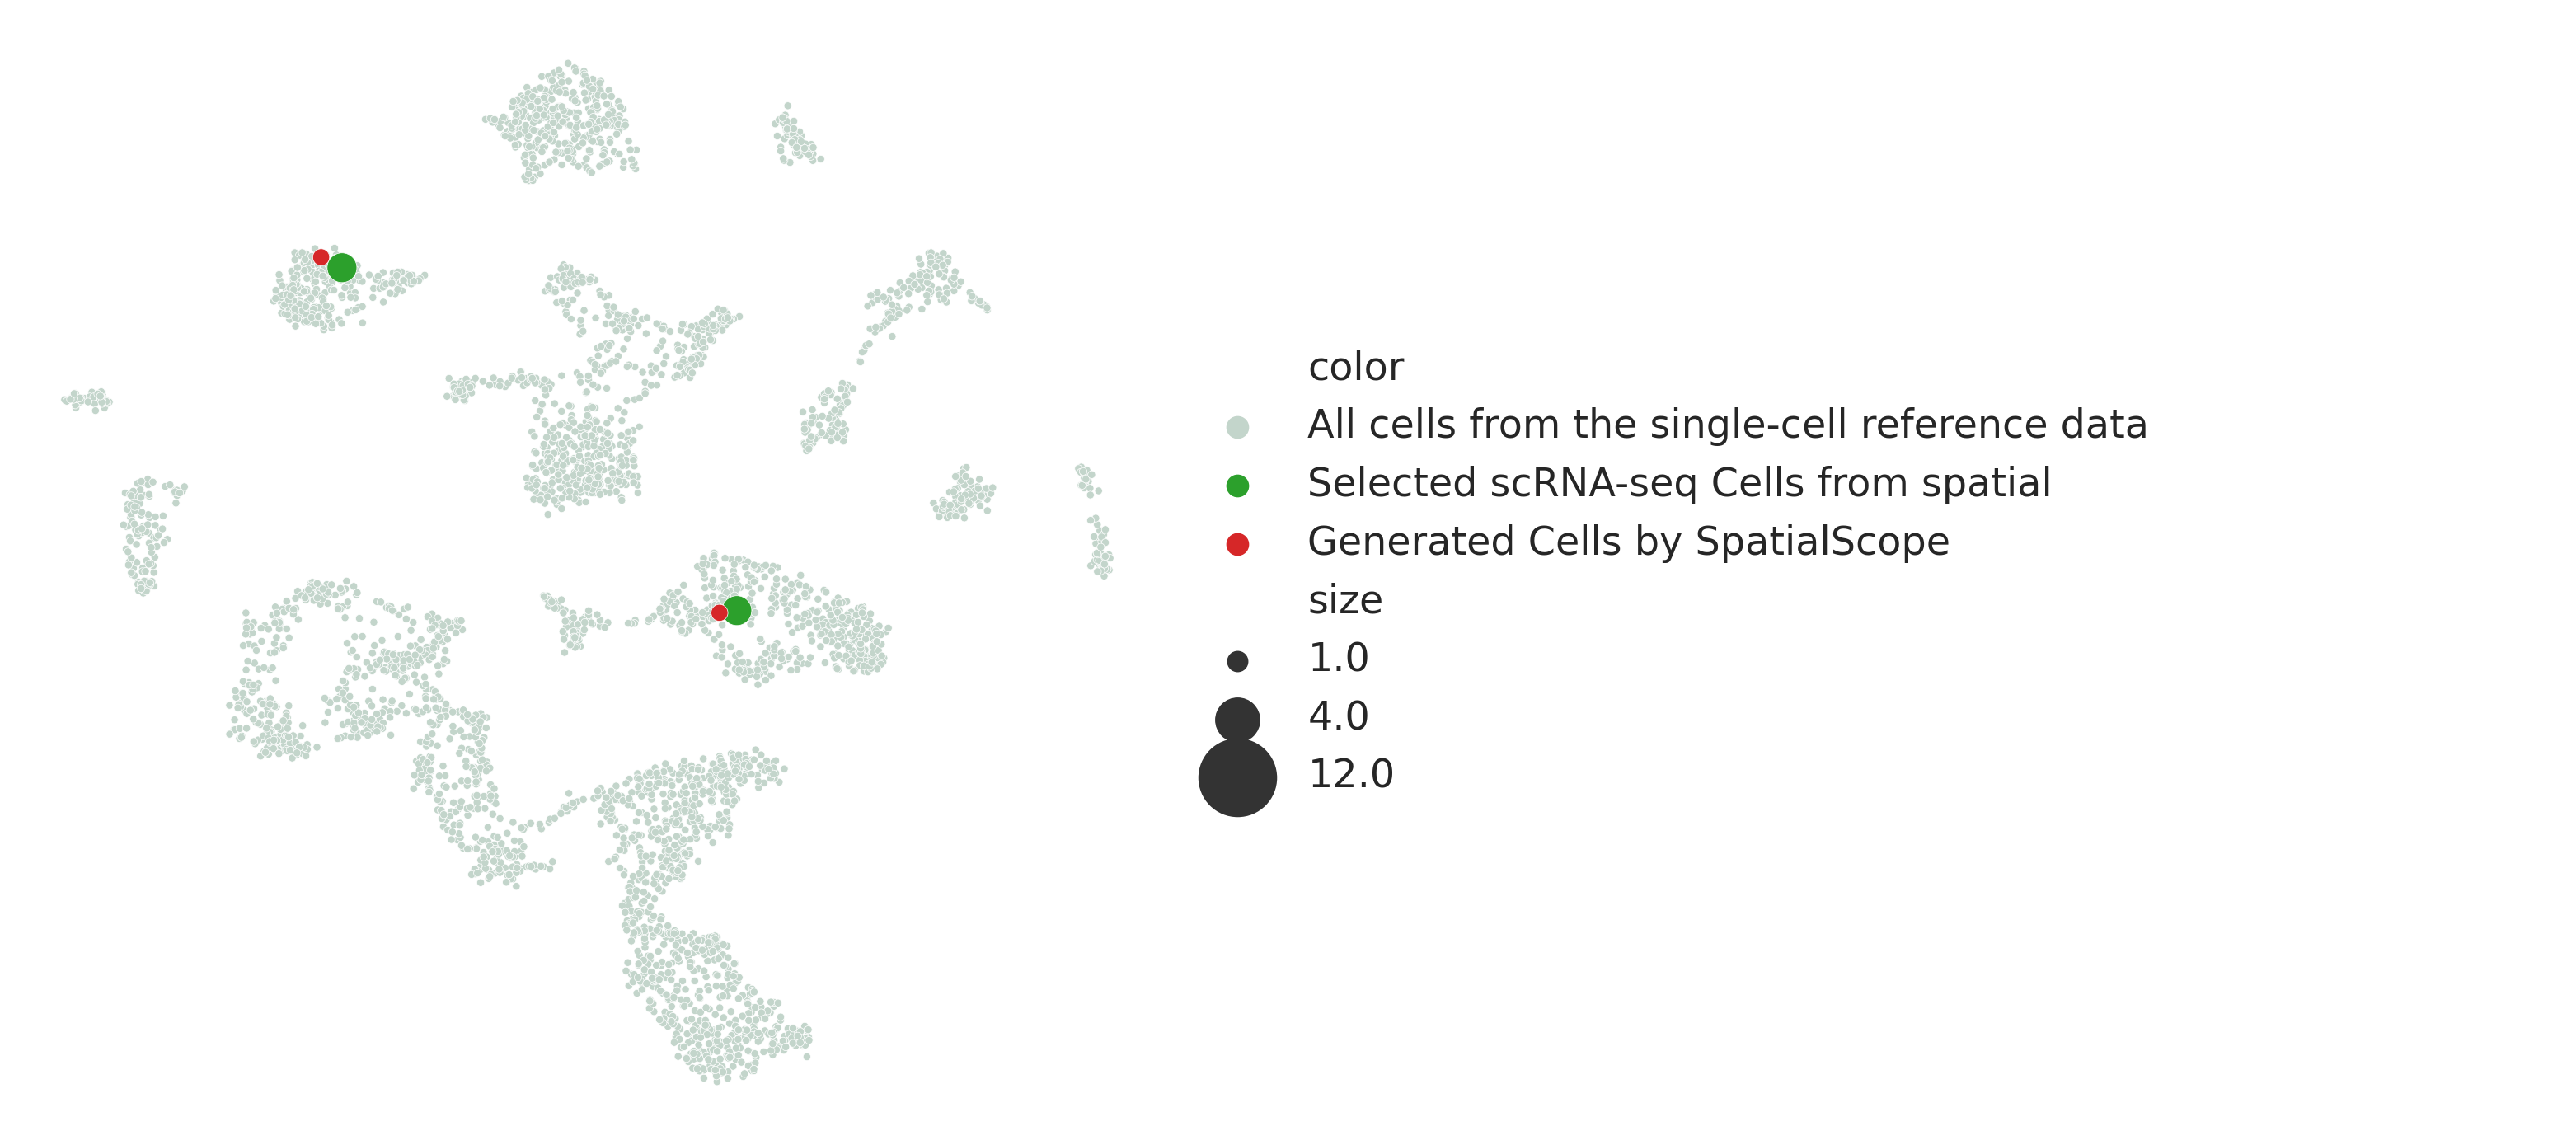

In [492]:
df_plot = pd.DataFrame(adata_all.obsm['X_umap'], columns = ['x', 'y'])
color_mu = np.ones(df_plot.shape[0])
color_mu[-(n_cells + n_cells_ss):-(n_cells_ss)] = 12
color_mu[-(n_cells_ss):] = 4
df_plot['size'] = color_mu
color_mu = np.array(['All cells from the single-cell reference data                                ' for _ in range(df_plot.shape[0])])
color_mu[-(n_cells + n_cells_ss):-(n_cells_ss)] = 'Selected scRNA-seq Cells from spatial'
color_mu[-(n_cells_ss):] = 'Generated Cells by SpatialScope'
df_plot['color'] = color_mu


# sns.set_context('paper',font_scale=3) 
# plt.rcParams["legend.markerscale"] = 3

sns.set_style('white')
sns.set_context('paper',font_scale=2.6)
plt.rcParams["legend.markerscale"] = 2.6
colors = ['#C3D5CB','#2ca02c','#d62728','#9467bd','#ff7f0e']
fig, ax = plt.subplots(1,1,figsize = (12,12),dpi = 150)
# sns.scatterplot(data=df_plot, x="x", y="y", hue="color", size = 'size', sizes = (20,300), style = 'style', markers={"y": "s", "o": "o", 's': '^'}, palette = sns.set_palette(sns.color_palette(colors)), ax = ax, legend = True)
sns.scatterplot(data=df_plot, x="x", y="y", hue="color", size = 'size', sizes = (20,300), palette = sns.set_palette(sns.color_palette(colors)), ax = ax, legend = True)
#     h,l = ax.get_legend_handles_labels()
#     legend = plt.legend(h[0:10],l[0:10],bbox_to_anchor=(1.12,.05),markerscale=2,framealpha=0)
#     legend.texts[0].set_text('')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('')
plt.ylabel('')
plt.axis('off')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()


# StarDist + RCTD and nu test

## Run SpatialScope

```
declare -a arr=("0" "5" "10" "20" "30" "40" "50" "60" "70" "80" "90" "100" "120" "150" "200" "500" "1000")

for rep in {0..9}

do 

for i in 0 5 10 20 30 40 50 60 70 80 90 100 120 150 200 500 1000

do

python ./src/Cell_Type_Identification.py \
--cell_class_column subclass \
--tissue "rep$rep" \
--out_dir ./output/RCTDnv_MOp/260UMI \
--ST_Data ./demo_data/simulation/260UMI/spatial.h5ad \
--SC_Data ./Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad \
--hs_ST \
--UMI_min_sigma 100 \
--nu $i

done
done

```


## Run StarDist + RCTD

```
for rep in {0..9}

do 

python ./compared_methods/SDRCTD.py \
--out_dir ./output/RCTDnv_MOp/260UMI/rep$rep \
--ST_Data ./demo_data/simulation/260UMI/spatial.h5ad \
--SC_Data ./Ckpts_scRefs/MERFISH_MOp_4Kcells/MERFISH_MOp_4Kcells.h5ad \
--cell_class_column subclass \
--cell_num_column cell_nums \
--hs_ST \

done

```

## StarDist + RCTD Results

In [26]:
DataDir = './output/RCTDnv_MOp/260UMI'
SR_dir = os.path.join(DataDir, 'rep0', 'SDRCTD_results')
SR_dir

'/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep0/SDRCTD_results'

## nu test

In [14]:
def ssim(im1,im2,M=1):
    im1, im2 = im1/im1.max(), im2/im2.max()
    mu1 = im1.mean()
    mu2 = im2.mean()
    sigma1 = np.sqrt(((im1 - mu1) ** 2).mean())
    sigma2 = np.sqrt(((im2 - mu2) ** 2).mean())
    sigma12 = ((im1 - mu1) * (im2 - mu2)).mean()
    k1, k2, L = 0.01, 0.03, M
    C1 = (k1*L) ** 2
    C2 = (k2*L) ** 2
    C3 = C2/2
    l12 = (2*mu1*mu2 + C1)/(mu1 ** 2 + mu2 ** 2 + C1)
    c12 = (2*sigma1*sigma2 + C2)/(sigma1 ** 2 + sigma2 ** 2 + C2)
    s12 = (sigma12 + C3)/(sigma1*sigma2 + C3)
    ssim = l12 * c12 * s12
    return ssim

def rmse(x1,x2):
    return mean_squared_error(x1,x2,squared=False)
def mae(x1,x2):
    return np.mean(np.abs(x1-x2))

from collections.abc import Iterable
def compare_results(gd,result_list,metric='pcc',columns=None,axis=1):
    if metric=='pcc':
        func = pearsonr
        r_ind = 0
    if metric=='mae':
        func = mae
        r_ind = None
    if metric=='jsd':
        func = jensenshannon
        r_ind = None
    if metric=='rmse':
        func = rmse
        r_ind = None
    if metric=='ssim':
        func = ssim
        r_ind = None
    if isinstance(result_list, pd.DataFrame):
        c_list = []
        if axis == 1:
            print('axis: ',1)
            for i,c in enumerate(gd.columns):
                r = func(gd.iloc[:,i].values, np.clip(result_list.iloc[:,i],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        else:
            print('axis: ',0)
            for i,c in enumerate(gd.index):
                r = func(gd.iloc[i,:].values, np.clip(result_list.iloc[i,:],0,1))
                if isinstance(result_list, Iterable):
                    if r_ind is not None:
                        r = r[r_ind]
                c_list.append(r)
        df = pd.DataFrame(c_list,index=gd.columns,columns=columns)
    else:
        df_list = []
        for res in result_list:
            c_list = []
            if axis == 1:
                for i,c in enumerate(gd.columns):
                    r = func(gd.iloc[:,i].values, np.clip(res.iloc[:,i],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.columns)
            else:
                for i,c in enumerate(gd.index):
                    r = func(gd.iloc[i,:].values, np.clip(res.iloc[i,:],0,1))
                    if isinstance(res, Iterable):
                        if r_ind is not None:
                            r = r[r_ind]
                    c_list.append(r)
                df_tmp = pd.DataFrame(c_list,index=gd.index)
            df_list.append(df_tmp)
        df = pd.concat(df_list,axis=1)
        df.columns = columns
    return df


In [11]:
def label_to_matrix(spot_label, label):
    matrix = pd.DataFrame(index = np.unique(spot_label), columns = np.unique(np.array(label)))
    for i in np.unique(spot_label):
        each_spot_prop_df = pd.DataFrame(index = np.unique(np.array(label)))
        each_spot_prop_df['prop'] = np.zeros(each_spot_prop_df.shape[0])
        index = spot_label == i
        val, counts = np.unique(label[index], return_counts=True)
        each_spot_prop_df.loc[val, 'prop'] = counts
        matrix.loc[i,:] = each_spot_prop_df.values.squeeze()

    return matrix

gd_results = label_to_matrix(np.array(sp_adata.uns['cell_locations']['spot_index_int']), np.array(sp_adata.uns['cell_locations'][sp_cell_class_column]))
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.fillna(0)

In [72]:
nu_list = [0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']

error_rate_df = pd.DataFrame(columns = {'error_rate', 'nu', 'rep'})
decon_df = pd.DataFrame()
decon_pcc_df = pd.DataFrame()
decon_rmse_df = pd.DataFrame()

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
        
        with open(os.path.join(DataDir, 'rep' + str(rep), 'InitProp.pickle'), 'rb') as handle:
            InitProp = pickle.load(handle)

        RCTD_results = (InitProp['results'] / np.array(InitProp['results'].sum(1))[:, None])
        RCTD_results = RCTD_results.loc[:, np.unique(RCTD_results.columns)]
        if rep == 0:
            print(os.path.join(DataDir, 'rep' + str(rep), 'RCTD_results.txt'))
            RCTD_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'RCTD_results.txt'))
            
        
        SR_results = sc.read(os.path.join(DataDir, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
        SR_cell_type_label = SR_results.uns['cell_locations'].copy()
        prop = label_to_matrix(np.array(SR_cell_type_label['spot_index_int']), np.array(SR_cell_type_label['SDRCTD_cell_type']))
        prop = prop/prop.sum(1)[:,None]

        SR_results = prop
        SR_results.index = np.arange(len(SR_results))
        SR_results = SR_results.loc[:,np.unique(SR_results.columns)]

        if rep == 0:
            print(os.path.join(DataDir, 'rep' + str(rep), 'SR_results.txt'))
            SR_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'SR_results.txt'))
            
        if nu == 'RCTD':  
            estimated = np.array(SR_cell_type_label['SDRCTD_cell_type'])
            estimated = np.array([_.replace('_','/') for _ in estimated])
            tl = np.array(SR_cell_type_label[sp_cell_class_column])
            error_index = tl != estimated
            SR_cell_type_label['error'] = (error_index).astype(int) 
            RCTD_error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': RCTD_error_rate, 'nu': nu, 'rep': int(rep)}
        else:
            # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
            cell_locations = pd.read_csv(os.path.join(DataDir, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

            prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
            prop = prop/prop.sum(1)[:,None]

            SpatialScope_results = prop
            SpatialScope_results.index = np.arange(len(RCTD_results))
            SpatialScope_results = SpatialScope_results.loc[:,np.unique(SpatialScope_results.columns)]
            print(os.path.join(DataDir, 'rep' + str(rep), 'SpatialScope_result'+ '_nu' + str(nu) +'.txt'))
            SpatialScope_results.to_csv(os.path.join(DataDir, 'rep' + str(rep), 'SpatialScope_result'+ '_nu' + str(nu) +'.txt'))

            RCTD_results = RCTD_results.loc[:,gd_results.columns]
            SR_results = SR_results.loc[:,gd_results.columns]
            SpatialScope_results = SpatialScope_results.loc[:,gd_results.columns]            
            
            starmap_spots_pcc = compare_results(
                gd_results,
                [RCTD_results,SR_results, SpatialScope_results],
                columns = ['RCTD', 'SR', 'SpatialScope'],
                axis=0,
                metric='pcc'
            )

            starmap_spots_rmse = compare_results(
                gd_results,
                [RCTD_results,SR_results, SpatialScope_results],
                columns = ['RCTD', 'SR', 'SpatialScope'],
                axis=0,
                metric='rmse'
            )

            starmap_spots_pcc['nu'] = [int(nu)] * starmap_spots_pcc.shape[0]
            starmap_spots_pcc['metric'] = ['pcc'] * starmap_spots_pcc.shape[0]
            starmap_spots_rmse['nu'] = [int(nu)] * starmap_spots_rmse.shape[0]
            starmap_spots_rmse['metric'] = ['rmse'] * starmap_spots_rmse.shape[0]
            
            starmap_spots_pcc['cell_nums'] = starmap_spots_rmse['cell_nums'] = sp_adata.obs.cell_nums.tolist()

            decon_df = pd.concat([decon_df, starmap_spots_pcc, starmap_spots_rmse], axis = 0)
            decon_pcc_df = pd.concat([decon_pcc_df, starmap_spots_pcc], axis = 0)
            decon_rmse_df = pd.concat([decon_rmse_df, starmap_spots_rmse], axis = 0)


            estimated = np.array(cell_locations['discrete_label_ct'])
            estimated = np.array([_.replace('_','/') for _ in estimated])
            tl = np.array(cell_locations[sp_cell_class_column])
            error_index = tl != estimated
            cell_locations['error'] = (error_index).astype(int) 
            error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': int(nu), 'rep': int(rep)}               
        

nu = 1e-06; rep = 0
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep0/RCTD_results.txt
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep0/SR_results.txt
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep0/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 1
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep1/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 2
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep2/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 3
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep3/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 4
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep4/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 5
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep5/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 6
/home/share/xwanaf/sour_sep/revision/data/RCTDnv_MOp/260UMI/rep6/SpatialScope_result_nu1e-06.txt
nu = 1e-06; rep = 7

In [73]:
decon_df.to_csv(os.path.join(DataDir, 'decon_df.csv'))
error_rate_df.to_csv(os.path.join(DataDir, 'error_rate_df.csv'))

## error rate 

In [126]:
# nu_list = [0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']
# nu_list = [0, 0.000001, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']
nu_list = [0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['RCTD']

error_rate_df = pd.DataFrame(columns = {'error_rate', 'nu', 'rep'})

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
            
        ################################################################################################################## StarDist + RCTD resutls
        if nu == 'RCTD':  
            SR_results = sc.read(os.path.join(DataDir, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
            SR_cell_type_label = SR_results.uns['cell_locations'].copy()
        
            estimated = np.array(SR_cell_type_label['SDRCTD_cell_type'])
            tl = np.array(SR_cell_type_label[sp_cell_class_column])
            error_index = tl != estimated
            SR_cell_type_label['error'] = (error_index).astype(int) 
            RCTD_error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': RCTD_error_rate, 'nu': nu, '3D': False, 'rep': int(rep)}
        
        ################################################################################################################## StarDist + RCTD error rate
        else:
            # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
            cell_locations = pd.read_csv(os.path.join(DataDir, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

#             cell_locations = cell_locations[cell_locations.cell_nums == 1]
            
            estimated = np.array(cell_locations['discrete_label_ct'])
            tl = np.array(cell_locations[sp_cell_class_column])
            error_index = tl != estimated
            cell_locations['error'] = (error_index).astype(int) 
            error_rate = np.where((error_index).astype(int) == 1)[0].shape[0]/ error_index.shape[0]
            if isinstance(nu, int):
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': int(nu), 'rep': int(rep)}
            else:
                error_rate_df.loc[len(error_rate_df.index)] = {'error_rate': error_rate, 'nu': nu, 'rep': int(rep)}    
                
        

nu = 0; rep = 0
nu = 0; rep = 1
nu = 0; rep = 2
nu = 0; rep = 3
nu = 0; rep = 4
nu = 0; rep = 5
nu = 0; rep = 6
nu = 0; rep = 7
nu = 0; rep = 8
nu = 0; rep = 9
nu = 5; rep = 0
nu = 5; rep = 1
nu = 5; rep = 2
nu = 5; rep = 3
nu = 5; rep = 4
nu = 5; rep = 5
nu = 5; rep = 6
nu = 5; rep = 7
nu = 5; rep = 8
nu = 5; rep = 9
nu = 10; rep = 0
nu = 10; rep = 1
nu = 10; rep = 2
nu = 10; rep = 3
nu = 10; rep = 4
nu = 10; rep = 5
nu = 10; rep = 6
nu = 10; rep = 7
nu = 10; rep = 8
nu = 10; rep = 9
nu = 20; rep = 0
nu = 20; rep = 1
nu = 20; rep = 2
nu = 20; rep = 3
nu = 20; rep = 4
nu = 20; rep = 5
nu = 20; rep = 6
nu = 20; rep = 7
nu = 20; rep = 8
nu = 20; rep = 9
nu = 30; rep = 0
nu = 30; rep = 1
nu = 30; rep = 2
nu = 30; rep = 3
nu = 30; rep = 4
nu = 30; rep = 5
nu = 30; rep = 6
nu = 30; rep = 7
nu = 30; rep = 8
nu = 30; rep = 9
nu = 40; rep = 0
nu = 40; rep = 1
nu = 40; rep = 2
nu = 40; rep = 3
nu = 40; rep = 4
nu = 40; rep = 5
nu = 40; rep = 6
nu = 40; rep = 7
nu = 40; rep = 8
nu = 40; rep = 9


In [127]:
vis_nu_list = [0, 5] + np.arange(10,110,10).tolist() + [120, 150, 200, 500, 1000] + ['StarDist \n + RCTD']

In [129]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=4) 
fig, ax = plt.subplots(1,1, figsize = (40, 8), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

palette = ['#EB8E83'] * (len(vis_nu_list) - 1) + ['#D8A8EB']
with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue='subsample',data=vis_df[(vis_df['correct_label'])&(vis_df['cell_num']==1)], palette="Set3", ax = ax)
    sns.barplot(x="nu", y="error_rate",data=error_rate_df, palette=palette, ax = ax)
ax.set_ylim(0.17,0.32)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(vis_nu_list)

plt.xlabel(r'$\nu$ value & StarDist + RCTD')
plt.axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.show()

In [128]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (24, 8), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="error_rate",hue='subsample',data=vis_df[(vis_df['correct_label'])&(vis_df['cell_num']==1)], palette="Set3", ax = ax)
    sns.barplot(x="nu", y="error_rate",data=error_rate_df, palette="Set3", ax = ax)
ax.set_ylim(0.17,0.32)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(vis_nu_list)

plt.xlabel(r'$\nu$ value & StarDist + RCTD')
plt.axhline(y=error_rate_df[error_rate_df['nu'] == 'RCTD'].error_rate.mean(), color='r', linestyle='--')
plt.show()

## deconvolution


In [85]:
decon_df = decon_df.astype({'nu':'int'})

In [86]:
vis_decon_df = pd.DataFrame()
vis_decon_df['value'] = decon_df.RCTD.tolist() + decon_df.SR.tolist() + decon_df.SpatialScope.tolist()
vis_decon_df['method'] = ['RCTD'] * decon_df.shape[0] + ['StarDist+RCTD'] * decon_df.shape[0] + ['SpatialScope'] * decon_df.shape[0]
vis_decon_df['nu'] = decon_df.nu.tolist() * 3
vis_decon_df['metric'] = decon_df.metric.tolist() * 3

In [90]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'rmse'], palette=['#EA8E83', '#AFCF78', '#8AAEC9'], ax = ax)
# ax.set_ylim(0.4,0.95)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6))
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.ylabel('RMSE')
plt.xlabel(r'$\nu$ value')
plt.show()

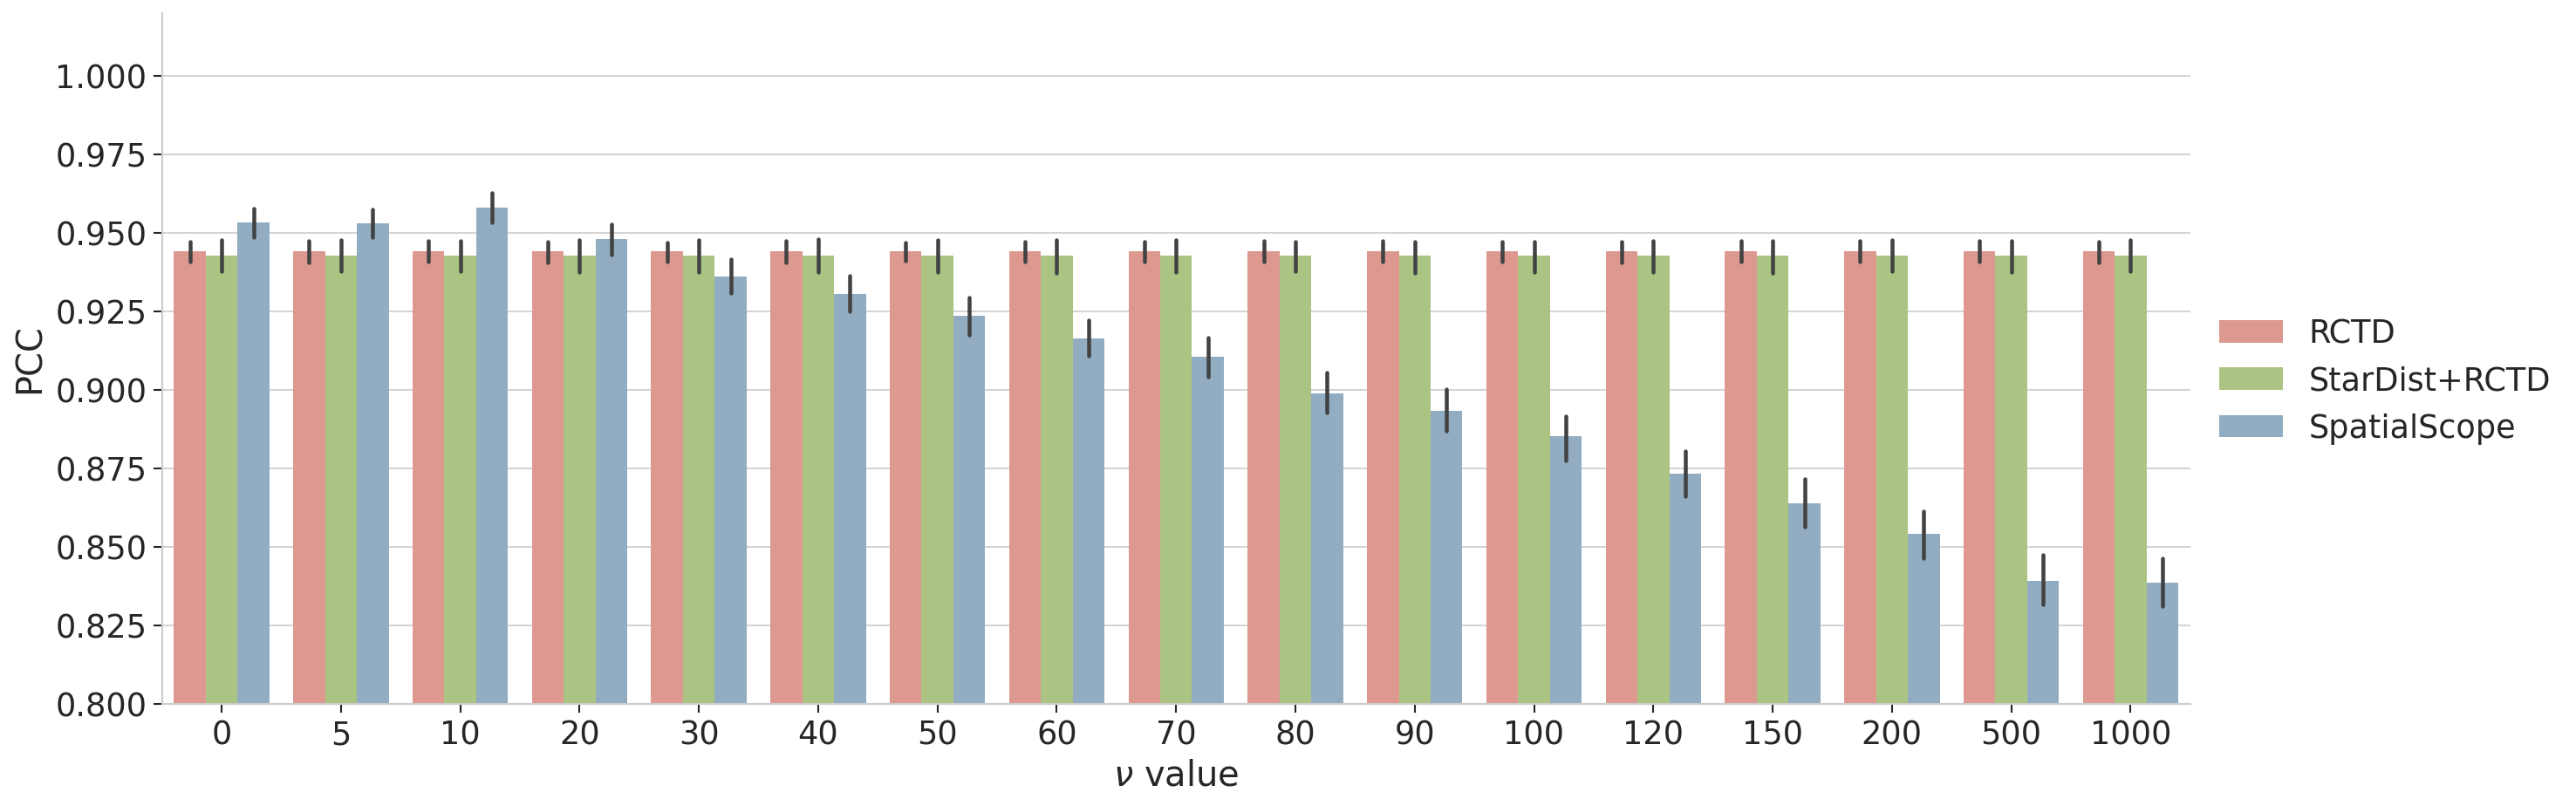

In [89]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
plt.style.use('seaborn-whitegrid')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (20, 7), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
    sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[vis_decon_df.metric == 'pcc'], palette=['#EA8E83', '#AFCF78', '#8AAEC9'], ax = ax)
ax.set_ylim(0.8,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(bbox_to_anchor=(1,0.6))
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.ylabel('PCC')
plt.xlabel(r'$\nu$ value')
plt.show()

# add nv = 0

In [15]:
nu_list = [0]

decon_df_temp = pd.DataFrame()

for j, nu in enumerate(nu_list):
    for i, rep in enumerate(range(10)):
        print(f"nu = {nu}; rep = {rep}")
        
        with open(os.path.join(DataDir, 'rep' + str(rep), 'InitProp.pickle'), 'rb') as handle:
            InitProp = pickle.load(handle)

        RCTD_results = (InitProp['results'] / np.array(InitProp['results'].sum(1))[:, None])
        RCTD_results = RCTD_results.loc[:, np.unique(RCTD_results.columns)]
        
        SR_results = sc.read(os.path.join(DataDir, 'rep' + str(rep), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
        SR_cell_type_label = SR_results.uns['cell_locations'].copy()
        prop = label_to_matrix(np.array(SR_cell_type_label['spot_index_int']), np.array(SR_cell_type_label['SDRCTD_cell_type']))
        prop = prop/prop.sum(1)[:,None]

        SR_results = prop
        SR_results.index = np.arange(len(SR_results))
        SR_results = SR_results.loc[:,np.unique(SR_results.columns)]

  
        # palette = ['#F0EFF6', '#D0E2F8', '#c44e52']
        cell_locations = pd.read_csv(os.path.join(DataDir, 'rep' + str(rep), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

        prop = label_to_matrix(np.array(cell_locations['spot_index_int']), np.array(cell_locations['discrete_label_ct']))
        prop = prop/prop.sum(1)[:,None]

        SpatialScope_results = prop
        SpatialScope_results.index = np.arange(len(RCTD_results))
        SpatialScope_results = SpatialScope_results.loc[:,np.unique(SpatialScope_results.columns)]
        
        
        RCTD_results = RCTD_results.loc[:,gd_results.columns]
        SR_results = SR_results.loc[:,gd_results.columns]
        SpatialScope_results = SpatialScope_results.loc[:,gd_results.columns]            

        starmap_spots_pcc = compare_results(
            gd_results,
            [RCTD_results,SR_results, SpatialScope_results],
            columns = ['RCTD', 'SR', 'SpatialScope'],
            axis=0,
            metric='pcc'
        )

        starmap_spots_rmse = compare_results(
            gd_results,
            [RCTD_results,SR_results, SpatialScope_results],
            columns = ['RCTD', 'SR', 'SpatialScope'],
            axis=0,
            metric='rmse'
        )

        starmap_spots_pcc['nu'] = [int(nu)] * starmap_spots_pcc.shape[0]
        starmap_spots_pcc['metric'] = ['pcc'] * starmap_spots_pcc.shape[0]
        starmap_spots_rmse['nu'] = [int(nu)] * starmap_spots_rmse.shape[0]
        starmap_spots_rmse['metric'] = ['rmse'] * starmap_spots_rmse.shape[0]

        starmap_spots_pcc['cell_nums'] = starmap_spots_rmse['cell_nums'] = sp_adata.obs.cell_nums.tolist()

        decon_df_temp = pd.concat([decon_df_temp, starmap_spots_pcc, starmap_spots_rmse], axis = 0)


nu = 0; rep = 0
nu = 0; rep = 1
nu = 0; rep = 2
nu = 0; rep = 3
nu = 0; rep = 4
nu = 0; rep = 5
nu = 0; rep = 6
nu = 0; rep = 7
nu = 0; rep = 8
nu = 0; rep = 9


In [16]:
decon_df = pd.read_csv(os.path.join(DataDir, 'decon_df.csv'), index_col = 0)
decon_df = decon_df.loc[decon_df['nu'] != 1e-6]

In [17]:
decon_df = pd.concat([decon_df_temp, decon_df], axis = 0)

In [18]:
decon_df

RCTD        SR  SpatialScope      nu metric  cell_nums
0    0.990918  1.000000      1.000000     0.0    pcc          1
1    0.986867  1.000000      1.000000     0.0    pcc          2
2    0.992446  1.000000      1.000000     0.0    pcc          2
3    0.999982  1.000000      1.000000     0.0    pcc          1
4    0.997767  1.000000      1.000000     0.0    pcc          1
..        ...       ...           ...     ...    ...        ...
594  0.067176  0.114332      0.114332  1000.0   rmse          3
595  0.085412  0.000000      0.171499  1000.0   rmse          2
596  0.076971  0.000000      0.171499  1000.0   rmse          2
597  0.009371  0.000000      0.000000  1000.0   rmse          5
598  0.007560  0.000000      0.000000  1000.0   rmse          1

[203660 rows x 6 columns]

In [19]:
decon_df = decon_df.astype({'nu':'int'})

In [20]:
vis_decon_df = pd.DataFrame()
vis_decon_df['value'] = decon_df.RCTD.tolist() + decon_df.SR.tolist() + decon_df.SpatialScope.tolist()
vis_decon_df['method'] = ['RCTD'] * decon_df.shape[0] + ['StarDist+RCTD'] * decon_df.shape[0] + ['SpatialScope'] * decon_df.shape[0]
vis_decon_df['nu'] = decon_df.nu.tolist() * 3
vis_decon_df['metric'] = decon_df.metric.tolist() * 3

In [21]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
# plt.style.use('seaborn-whitegrid')
plt.style.use('default')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (12, 4), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[(vis_decon_df.metric == 'rmse')], palette=['#C1BED6', '#D8A8EB', '#EB8E83'], ax = ax)
    sns.barplot(x="nu", y="value",data=vis_decon_df[(vis_decon_df.metric == 'rmse') & (vis_decon_df['method'] == 'SpatialScope')], width = 0.5, palette=['#EB8E83'], ax = ax)
# ax.set_ylim(0.4,0.95)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend(bbox_to_anchor=(1,0.6))
# ax.legend_.remove()
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'RCTD') & (vis_decon_df['metric'] == 'rmse')].value.mean(), color='#C1BED6', linestyle='--', linewidth = 2.5)
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'StarDist+RCTD') & (vis_decon_df['metric'] == 'rmse')].value.mean(), color='#D8A8EB', linestyle='--', linewidth = 2.5)
plt.ylabel('RMSE')
plt.xlabel(r'$\nu$ value')
plt.show()

In [24]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
# plt.style.use('seaborn-whitegrid')
plt.style.use('default')

sns.set_context('paper',font_scale=2) 
fig, ax = plt.subplots(1,1, figsize = (12, 4), dpi = 150)
plt.subplots_adjust(hspace = 0.5)

with plt.style.context('seaborn-whitegrid'):
#     sns.barplot(x="nu", y="value",hue='method',data=vis_decon_df[(vis_decon_df.metric == 'pcc')], palette=['#C1BED6', '#D8A8EB', '#EB8E83'], ax = ax)
    sns.barplot(x="nu", y="value",data=vis_decon_df[(vis_decon_df.metric == 'pcc') & (vis_decon_df['method'] == 'SpatialScope')], width = 0.5, palette=['#EB8E83'], ax = ax)
ax.set_ylim(0.8,1.02)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# plt.legend(bbox_to_anchor=(1,0.6))
# ax.legend_.remove()
#ax.set_yticks([0.84, 0.86, 0.88])
#ax.set_xticklabels(['130 UMIs','260 UMIs','520 UMIs'])
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'RCTD') & (vis_decon_df['metric'] == 'pcc')].value.mean(), color='#C1BED6', linestyle='--', linewidth = 1.5)
plt.axhline(y=vis_decon_df[(vis_decon_df['method'] == 'StarDist+RCTD') & (vis_decon_df['metric'] == 'pcc')].value.mean(), color='#D8A8EB', linestyle='--', linewidth = 1.5)
plt.ylabel('PCC')
plt.xlabel(r'$\nu$ value')
plt.show()

## example results

In [91]:
nu = 10
cell_locations = pd.read_csv(os.path.join(DataDir, 'rep' + str(0), 'CellTypeLabel_nu' + str(nu) + '.csv'), index_col = 0)

SR_results = sc.read(os.path.join(DataDir, 'rep' + str(0), 'SDRCTD_results/single_cell_type_label_bySDRCTD.h5ad'))
SR_cell_type_label = SR_results.uns['cell_locations'].copy()

In [93]:
sp_adata = sc.read(os.path.join(DataDir, 'spatial.h5ad'))
sp_adata.obs[np.array(['x', 'y'])].to_csv(DataDir + '/gt_loc.txt')
gd_results.to_csv(DataDir + '/gt_res.txt')

## ground truth

In [117]:
with mpl.rc_context({'figure.figsize': (4, 12), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=cell_locations, x="x", y="y", hue=sp_cell_class_column, s = 55, palette = color_dict, legend = False)
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')

## SpatialScope

In [97]:
with mpl.rc_context({'figure.figsize': (4, 12), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=cell_locations, x="x", y="y", hue='discrete_label_ct', s = 50, palette = color_dict, legend = False)
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')

### StarDist + RCTD 

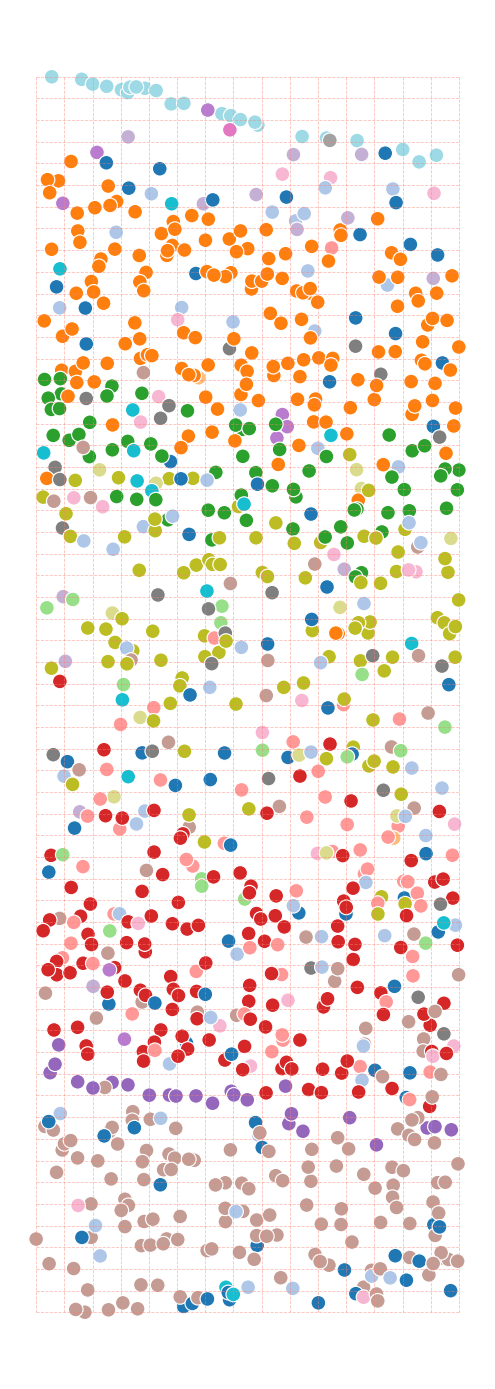

In [98]:
with mpl.rc_context({'figure.figsize': (4, 12), 'figure.dpi': 150}):
    ax = sns.scatterplot(data=SR_cell_type_label, x="x", y="y", hue='SDRCTD_cell_type', s = 50, palette = color_dict, legend = False)
    ax.invert_yaxis()
    for i in range(x_seg.shape[0]):
        ax.plot([x_seg[i] for _ in y_seg],y_seg,linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
    for i in range(y_seg.shape[0]):    
        ax.plot(x_seg,[y_seg[i] for _ in x_seg],linestyle='dashed', c = 'salmon', lw = .4, alpha = 0.5)
#         ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.axis('off')